In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib notebook
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import yfinance as yf
#because the is_list_like is moved to pandas.api.types
pd.core.common.is_list_like = pd.api.types.is_list_like
import ffn
#import pixiedust

[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>


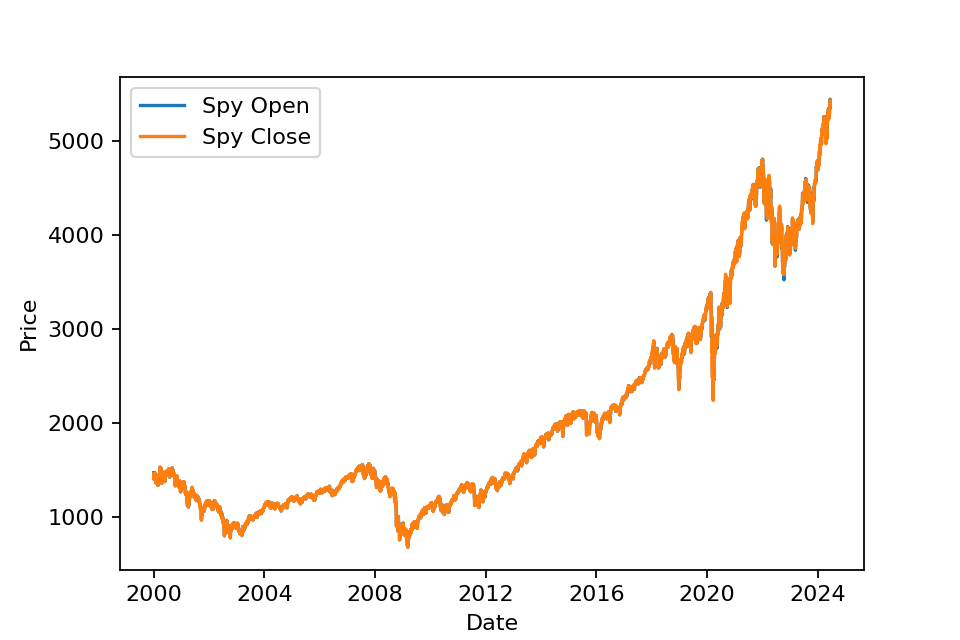

In [2]:
# Set display options for pandas
pd.set_option("max_colwidth", 100)
pd.set_option("display.max_rows", 100000)
pd.set_option("display.max_columns", 1000)

# Fetch data from Yahoo Finance
ticker = '^spx'
data = yf.download(ticker, start="2000-01-01", end="2024-06-15")
data.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
data['Adj_Open'] = data['Open'] * (data['Adj_Close'] / data['Close'])

# Select the required columns
pricing = data[['Adj_Open', 'Adj_Close']].reset_index()

# Plot the data
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pricing['Date'], pricing['Adj_Open'], label='Spy Open')
plt.plot(pricing['Date'], pricing['Adj_Close'], label='Spy Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [3]:
pricing.head()

,Date,Adj_Open,Adj_Close
0,2000-01-03,1469.250000,1455.219971
1,2000-01-04,1455.219971,1399.420044
2,2000-01-05,1399.420044,1402.109985
3,2000-01-06,1402.109985,1403.449951
4,2000-01-07,1403.449951,1441.469971


In [4]:
stock=pricing.copy()
stock.Adj_Close=stock.Adj_Close.shift(1)

stock.tail()

,Date,Adj_Open,Adj_Close
6147,2024-06-10,5341.220215,5346.990234
6148,2024-06-11,5353.000000,5360.790039
6149,2024-06-12,5409.129883,5375.319824
6150,2024-06-13,5441.930176,5421.029785
6151,2024-06-14,5424.080078,5433.740234


In [5]:
stock_1=stock.iloc[0:2170].copy()
stock_2=stock.iloc[2170:4342].copy().reset_index(drop=True)
stock_3=stock.iloc[4342:6513].copy().reset_index(drop=True) 
stock_2.head()

,Date,Adj_Open,Adj_Close
0,2008-08-20,1267.339966,1266.689941
1,2008-08-21,1271.069946,1274.540039
2,2008-08-22,1277.589966,1277.719971
3,2008-08-25,1290.469971,1292.199951
4,2008-08-26,1267.030029,1266.839966


In [6]:
def trade(stock, length):

    temp_dict = {}
    # If window length is 0, algorithm doesn't make sense, so exit
    if length == 0:
        return 0

    # Compute rolling means and rolling standard deviation
    #sma and lma are filters to prevent taking long or short positions against the longer term trend
    rolling_window = stock.Adj_Close.rolling(window=length)
    mu = rolling_window.mean()
    sma = stock.Adj_Close.rolling(window=length*1).mean()
    lma = stock.Adj_Close.rolling(window=length * 10).mean()
    std = rolling_window.std()

    #If you don't use a maximum position size the positions will keep on pyramidding.
    #Set max_position to a high number (1000?) to disable this parameter
    #Need to beware of unintended leverage
    max_position = 1
    percent_per_trade = 1.0

    #Slippage and commission adjustment  - simply reduces equity by a percentage guess
    # a setting of 1 means no slippage, a setting of 0.999 gives 0.1% slippage
    slippage_adj = 1

    # Compute the z-scores for each day using the historical data up to that day
    zscores = (stock.Adj_Close - mu) / std

    # Simulate trading
    # Start with your chosen starting capital and no positions
    money = 1000.00
    position_count = 0

    for i, row in enumerate(stock.itertuples(), 0):

        #set up position size so that each position is a fixed position of your account equity
        equity = money + (stock.Adj_Close[i] * position_count)
        if equity > 0:
            fixed_frac = (equity * percent_per_trade) / stock.Adj_Close[i]
        else:
            fixed_frac = 0
        fixed_frac = int(round(fixed_frac))

        #exit all positions if zscore flips from positive to negative or vice versa without going through
        #the neutral zone
        if i > 0:
            if (zscores[i - 1] > 0.5
                    and zscores[i] < -0.5) or (zscores[i - 1] < -0.5
                                               and zscores[i] > 0.5):

                if position_count > 0:
                    money += position_count * stock.Adj_Close[i] * slippage_adj
                elif position_count < 0:
                    money += position_count * stock.Adj_Close[i] * (
                        1 / slippage_adj)
                position_count = 0

        # Sell short if the z-score is > 1 and if the longer term trend is negative
        if (zscores[i] > 1) & (position_count > max_position * -1) & (sma[i] <
                                                                      lma[i]):

            position_count -= fixed_frac
            money += fixed_frac * stock.Adj_Close[i] * slippage_adj

        # Buy long if the z-score is < 1 and the longer term trend is positive
        elif zscores[i] < -1 and position_count < max_position and sma[i] > lma[i]:

            position_count += fixed_frac
            money -= fixed_frac * stock.Adj_Close[i] * (1 / slippage_adj)

        # Clear positions if the z-score between -.5 and .5
        elif abs(zscores[i]) < 0.5:
            #money += position_count * stock.Adj_Close[i]
            if position_count > 0:
                money += position_count * stock.Adj_Close[i] * slippage_adj
            elif position_count < 0:
                money += position_count * stock.Adj_Close[i] * (
                    1 / slippage_adj)
            position_count = 0

        #fill dictionary with the trading results.
        temp_dict[stock.Date[i]] = [
            stock.Adj_Open[i], stock.Adj_Close[i], mu[i], std[i], zscores[i],
            money, position_count, fixed_frac, sma[i], lma[i]
        ]
    #create a dataframe to return for use in calculating and charting the trading results
    pr = pd.DataFrame(data=temp_dict).T
    pr.index.name = 'Date'
    pr.index = pd.to_datetime(pr.index)
    pr.columns = [
        'Open', 'Close', 'mu', 'std', 'zscores', 'money', 'position_count',
        'fixed_frac', 'sma', 'lma'
    ]
    pr['equity'] = pr.money + (pr.Close * pr.position_count)
    #
    return pr

In [7]:
moving_average=10
profit = trade(stock, moving_average)

profit.tail()

,Open,Close,mu,std,zscores,money,position_count,fixed_frac,sma,lma,equity
Date,,,,,,,,,,,
2024-06-10,5341.220215,5346.990234,5301.941992,39.531424,1.139555,4066.061768,0.0,1.0,5301.941992,5113.564199,4066.061768
2024-06-11,5353.000000,5360.790039,5307.548975,43.723364,1.217680,4066.061768,0.0,1.0,5307.548975,5119.780000,4066.061768
2024-06-12,5409.129883,5375.319824,5314.476953,48.666935,1.250189,4066.061768,0.0,1.0,5314.476953,5125.723799,4066.061768
2024-06-13,5441.930176,5421.029785,5329.884912,55.814073,1.633009,4066.061768,0.0,1.0,5329.884912,5131.535996,4066.061768
2024-06-14,5424.080078,5433.740234,5349.710938,53.727523,1.563990,4066.061768,0.0,1.0,5349.710938,5137.369097,4066.061768


In [8]:
series=profit[['equity']].copy()

In [9]:
stats = series.calc_stats()
stats.display()

Stat                 equity
-------------------  ----------
Start                2000-01-04
End                  2024-06-14
Risk-free rate       0.00%

Total Return         306.61%
Daily Sharpe         0.62
Daily Sortino        0.96
CAGR                 5.91%
Max Drawdown         -24.70%
Calmar Ratio         0.24

MTD                  1.04%
3m                   1.33%
6m                   2.83%
YTD                  2.83%
1Y                   -4.43%
3Y (ann.)            0.21%
5Y (ann.)            2.03%
10Y (ann.)           1.63%
Since Incep. (ann.)  5.91%

Daily Sharpe         0.62
Daily Sortino        0.96
Daily Mean (ann.)    6.26%
Daily Vol (ann.)     10.11%
Daily Skew           0.35
Daily Kurt           23.66
Best Day             8.53%
Worst Day            -7.14%

Monthly Sharpe       0.74
Monthly Sortino      1.23
Monthly Mean (ann.)  6.10%
Monthly Vol (ann.)   8.26%
Monthly Skew         -0.02
Monthly Kurt         6.89
Best Month           15.35%
Worst Month          -9.72%

Yearly 

<IPython.core.display.Javascript object>


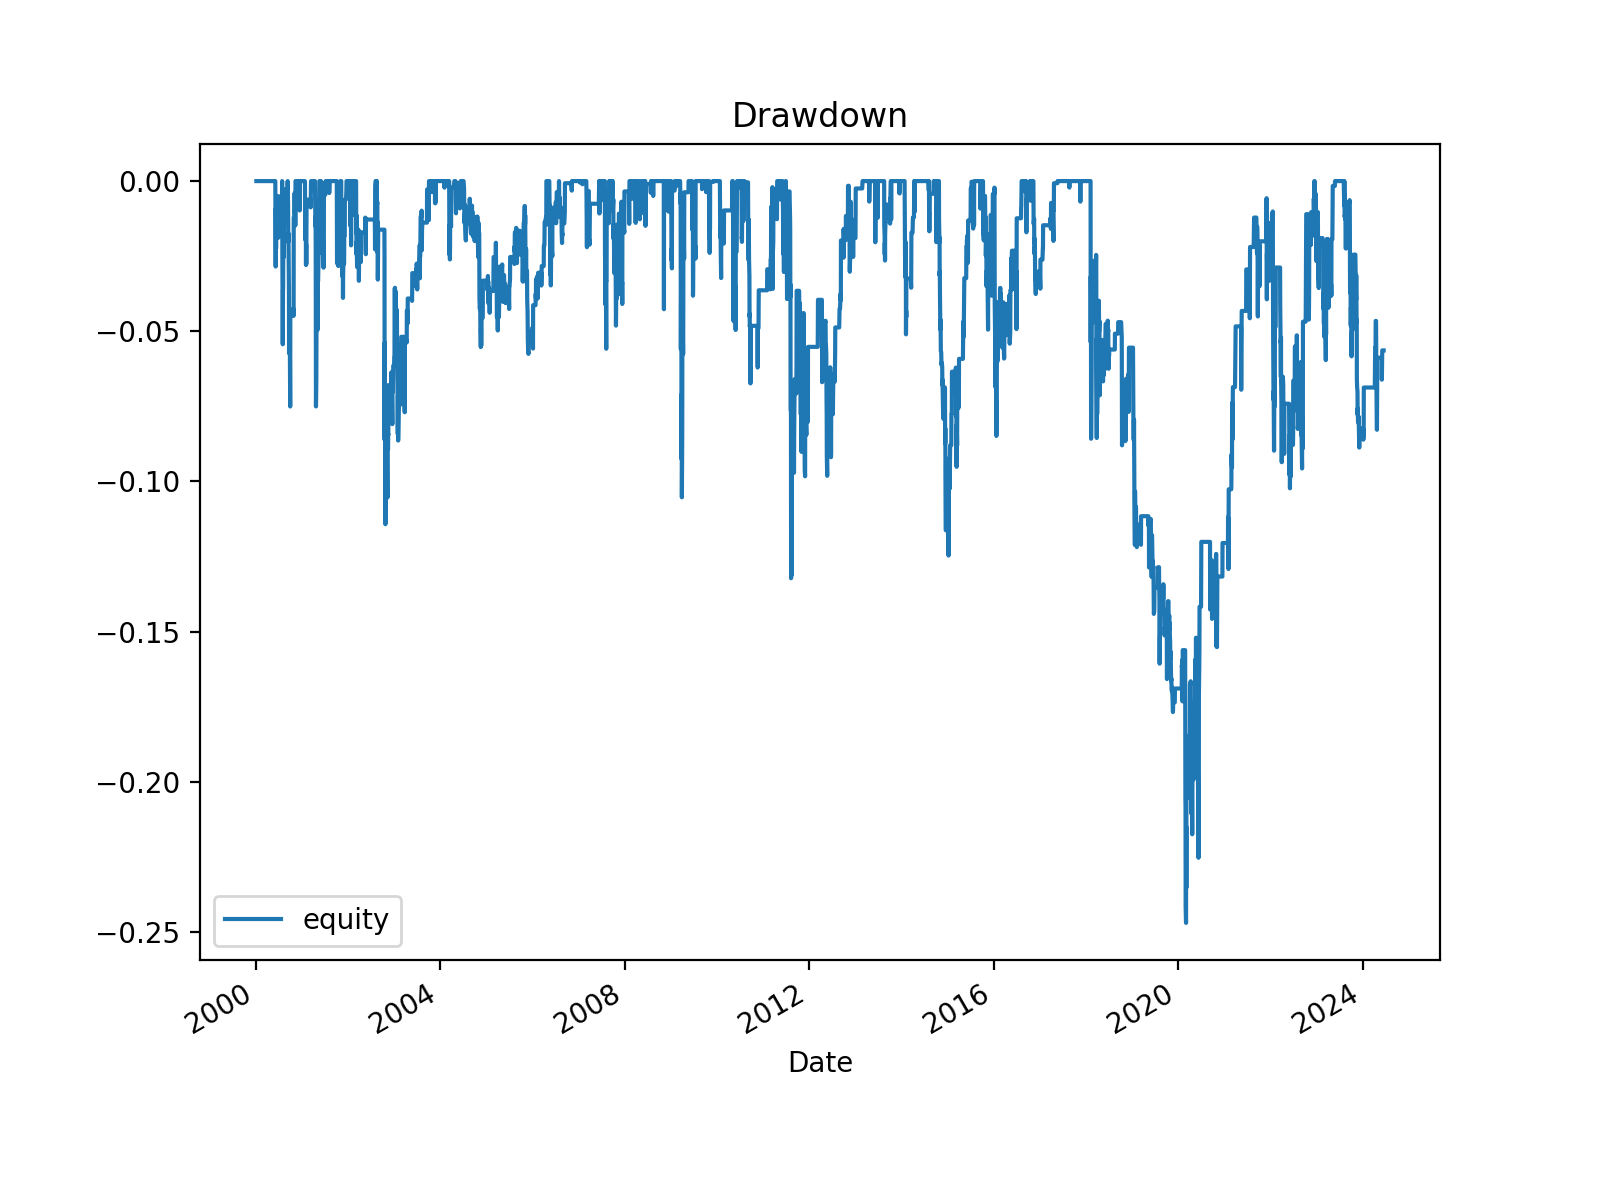

In [10]:
prices =series
ax = stats.prices.to_drawdown_series().plot(figsize=(8, 6),title='Drawdown')

<IPython.core.display.Javascript object>


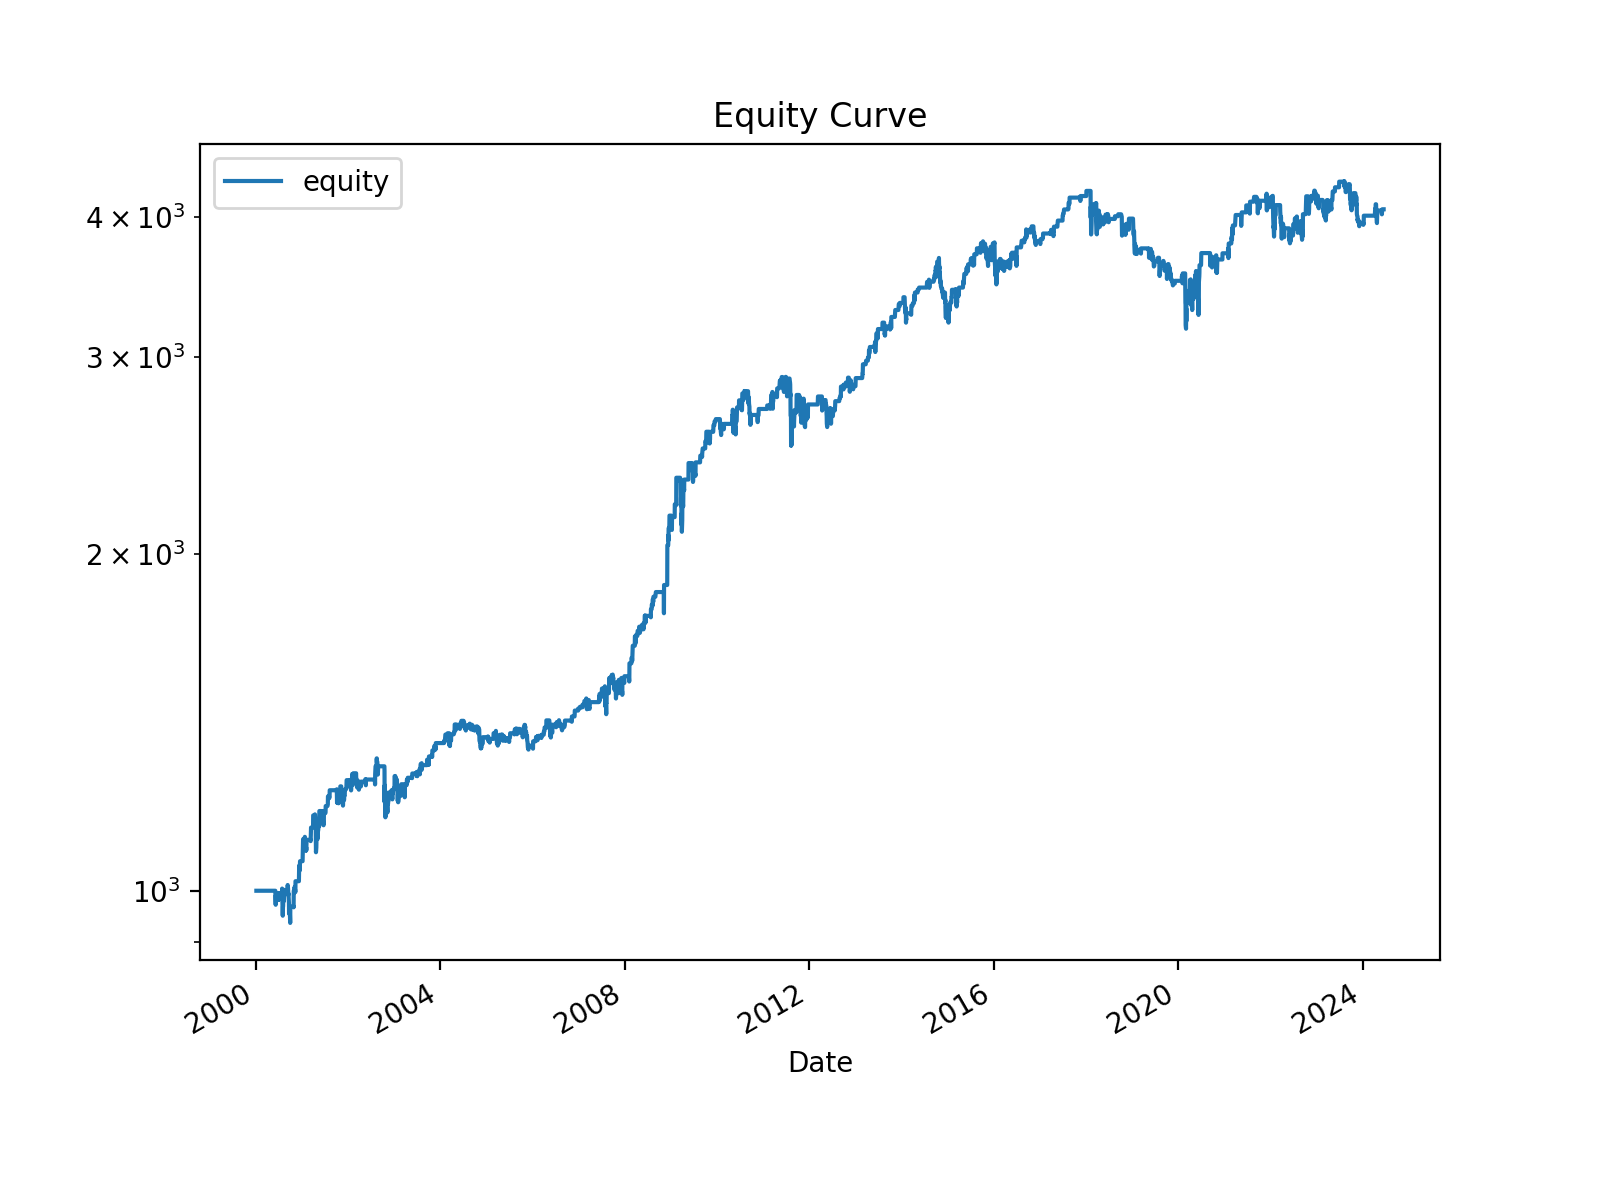

In [11]:
ax = prices.plot(logy=True,figsize=(8, 6),title='Equity Curve')